In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Functions we have developed in earlier assignnments

In [2]:
def get_outliers_df(df: pd.DataFrame, ignore_cols = []):
    result = pd.DataFrame()
    ignore_cols = set(ignore_cols)
    for col in df.columns.values:
        if col in ignore_cols:
            continue
        q1, q3 = np.percentile(df[col].to_numpy(), [25,75])
        iqr = q3-q1
        lower_boundary = q1 - (1.5*iqr)
        upper_boundary = q3 + (1.5 * iqr)
        upper_outliers = df.query(f'{col} > {upper_boundary}')[col]
        lower_outliers = df.query(f'{col} < {lower_boundary}')[col]
        result[f'{col}_outliers'] = pd.concat([upper_outliers, lower_outliers])
    return result
        

In [3]:
from sklearn.linear_model import LinearRegression

def random_imputation(df_to_impute: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    copy = df_to_impute.copy()
    for feature in features:
        copy[feature + '_imp'] = copy[feature]
        number_missing = copy[feature].isnull().sum()
        observed_values = copy.loc[copy[feature].notnull(), feature]
        copy.loc[copy[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return copy

def bootstrapped_stochastic_imputation(df_to_impute: pd.DataFrame, features: list[str]): 
    copy = df_to_impute.copy()
    df = random_imputation(copy, features)
    random_data = pd.DataFrame(columns = ["Ran" + name for name in features])

    for feature in features:
            
        random_data["Ran" + feature] = df[feature + '_imp']
        parameters = list(set(df.columns) - set(features) - {feature + '_imp'})
        
        model = LinearRegression()
        model.fit(X = df[parameters], y = df[feature + '_imp'])
        
        predict = model.predict(df[parameters])
        std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
        
        random_predict = np.random.normal(size = df[feature].shape[0], 
                                        loc = predict, 
                                        scale = std_error)
        random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                                (random_predict > 0)]
    for feature in features:
        copy[feature].fillna(random_data[f'Ran{feature}'],inplace=True)

    return copy


In [4]:

from pandas.io.formats.info import DataFrameInfo

def get_missing_count_ratio_df(df: pd.DataFrame):
    row_count, col_count = df.shape
    info = DataFrameInfo(data = df)
    info_df= pd.DataFrame(
        {'Non-Null Count': info.non_null_counts, 'Dtype': info.dtypes}
    )

    # Calculating missing data per column. 
    info_df['Missing Count'] = row_count- info_df['Non-Null Count']
    info_df['Missing Ratio'] = (info_df['Missing Count'] / row_count).astype(float)
    # Sorting missing data from highest % to lowest %
    return info_df.sort_values(by=['Non-Null Count'], ascending=True)

# 1. Analysis: Frame the problem and look at the big picture.

## Objective
To create a regression model that can predict house sales prices based on different features of the house. This can help people to determine if they are selling their house at the correct price. 

## Framing
This will utilize supervised learning, since we are doing regression to predict the sales price and the sales price is known for each house.

## Performance Measuring
Performance will be measured by different metrics related to regression such as coeffecient of determination ($R^2$) and Mean Squared Error (MSE).

### 2. Get the data

The dataset is from a Kaggle competition and can be found here: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv.

You must join the competition in order to get access to the data.

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.shape

(1460, 81)

In [8]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

### 3. Explore the data

In [9]:
eda = data.copy()

In [10]:
eda.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Exploring Missing Values

In [11]:
get_missing_count_ratio_df(eda).head(n=10)

,Non-Null Count,Dtype,Missing Count,Missing Ratio
PoolQC,7,object,1453,0.995205
MiscFeature,54,object,1406,0.963014
Alley,91,object,1369,0.937671
Fence,281,object,1179,0.807534
MasVnrType,588,object,872,0.597260
FireplaceQu,770,object,690,0.472603
LotFrontage,1201,float64,259,0.177397
GarageYrBlt,1379,float64,81,0.055479
GarageType,1379,object,81,0.055479
GarageFinish,1379,object,81,0.055479


We see that there are features where almost all the data is missing such as PoolQC, MiscFeature, Alley and more. We will now look further into the features where a signifcant part of the data is missing to attempt to get an understanding of why they are missing

Looking at the rows where it is not null

In [12]:
eda.loc[~eda["PoolQC"].isna()]["PoolQC"].value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

Only 7 rows have a value for Pool Quality, so the missing values might be because the house does not have a pool. We can verify this by looking at the PoolArea feature for the rows where PoolQC is missing.

In [13]:
eda.loc[eda["PoolQC"].isna()][["PoolQC", "PoolArea"]]

,PoolQC,PoolArea
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
1455,NaN,0
1456,NaN,0
1457,NaN,0
1458,NaN,0


In [14]:
eda.loc[eda["PoolQC"].isna()][["PoolQC", "PoolArea"]].query("PoolArea > 0")

,PoolQC,PoolArea


PoolQC is missing because they do not have a pool. According to `data_description.txt` this should have been set to `NA`, so we can replace the missing values with `NA` during preprocessing.

Now we will take a look at `MiscFeature`. `MiscFeature` is Miscellaneous feature not covered in other categories such as Elevator, 2nd Garage, Tennis Court and more.

In [15]:
eda.loc[~eda["MiscFeature"].isna()]["MiscFeature"].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

This feature has missing values because the house might not have any Miscellaneous features. We will verify this by checkign the `MiscVal` feature that indicates the value of the feature in dollars. 

In [16]:
eda.loc[eda["MiscFeature"].isna()][["MiscFeature", "MiscVal"]]

,MiscFeature,MiscVal
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
1454,NaN,0
1455,NaN,0
1456,NaN,0
1458,NaN,0


In [17]:
eda.loc[eda["MiscFeature"].isna()][["MiscFeature", "MiscVal"]].query("MiscVal > 0")

,MiscFeature,MiscVal


It would seem like `MiscFeature` has missing values because the house has no Miscellaneous features and they have not been put down as `NA` as specified in `data_description.txt`

In [18]:
eda.loc[~eda["Alley"].isna()]["Alley"].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

We notice that `Alley` also should have been classified as NA but has been put down as null instead.

The `Fence`, `MasVnrType`, `FireplaceQu` feature has missing values for the same reason as `PoolQC`, `MiscFeatures` and `Alley`

## Exploring Outliers

We first select all numerical features

In [34]:
eda_numerical = eda.select_dtypes([float, int])

In [57]:
import math
def boxplot_columns(df: pd.DataFrame, plots: int):
    column_bins = np.array(list(map(lambda x: math.floor(x), np.linspace(0, len(df.columns.values), num=plots))))
    prev = 0
    curr = 0
    for column_idx in column_bins[1:]:
        curr = column_idx if curr == 0 else column_idx - 1
        plt.figure(figsize=(15,10))
        df[df.columns.values[prev:curr]].boxplot()
        plt.show()
        prev = curr

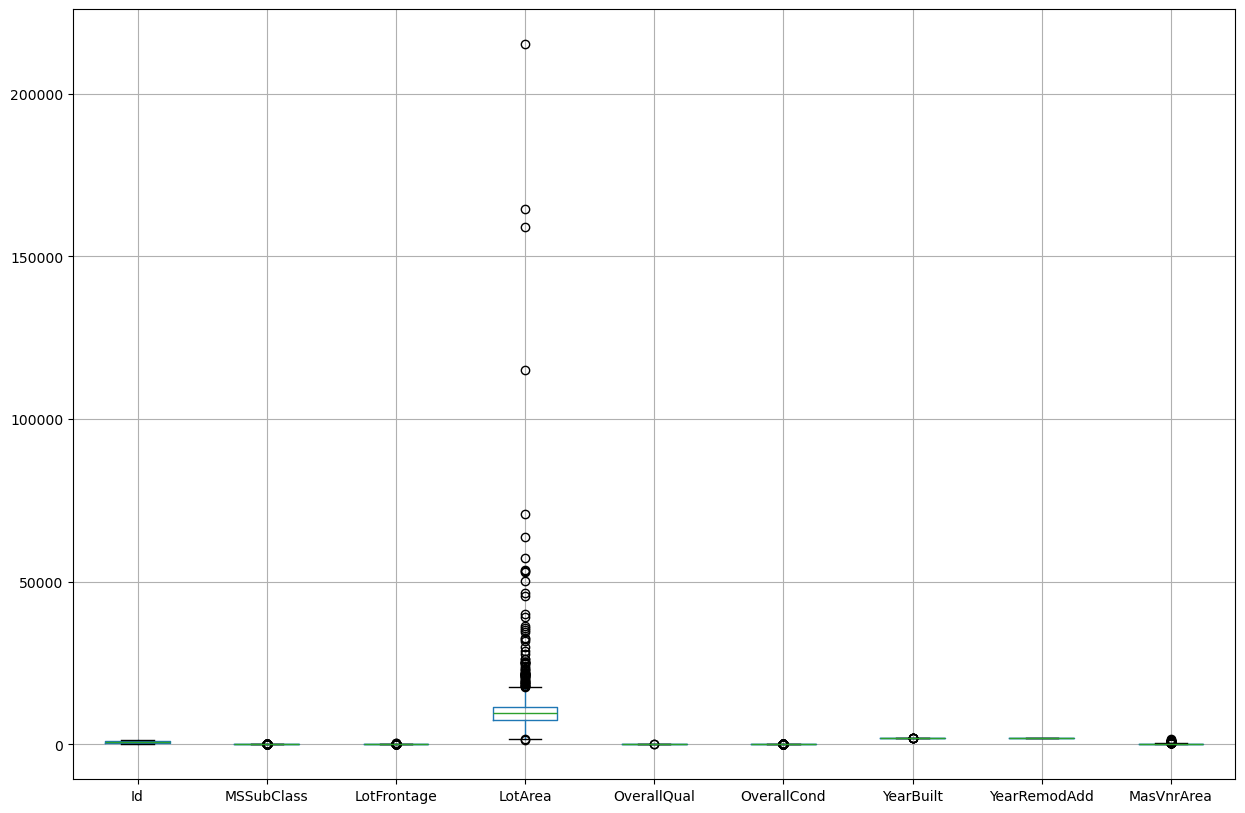

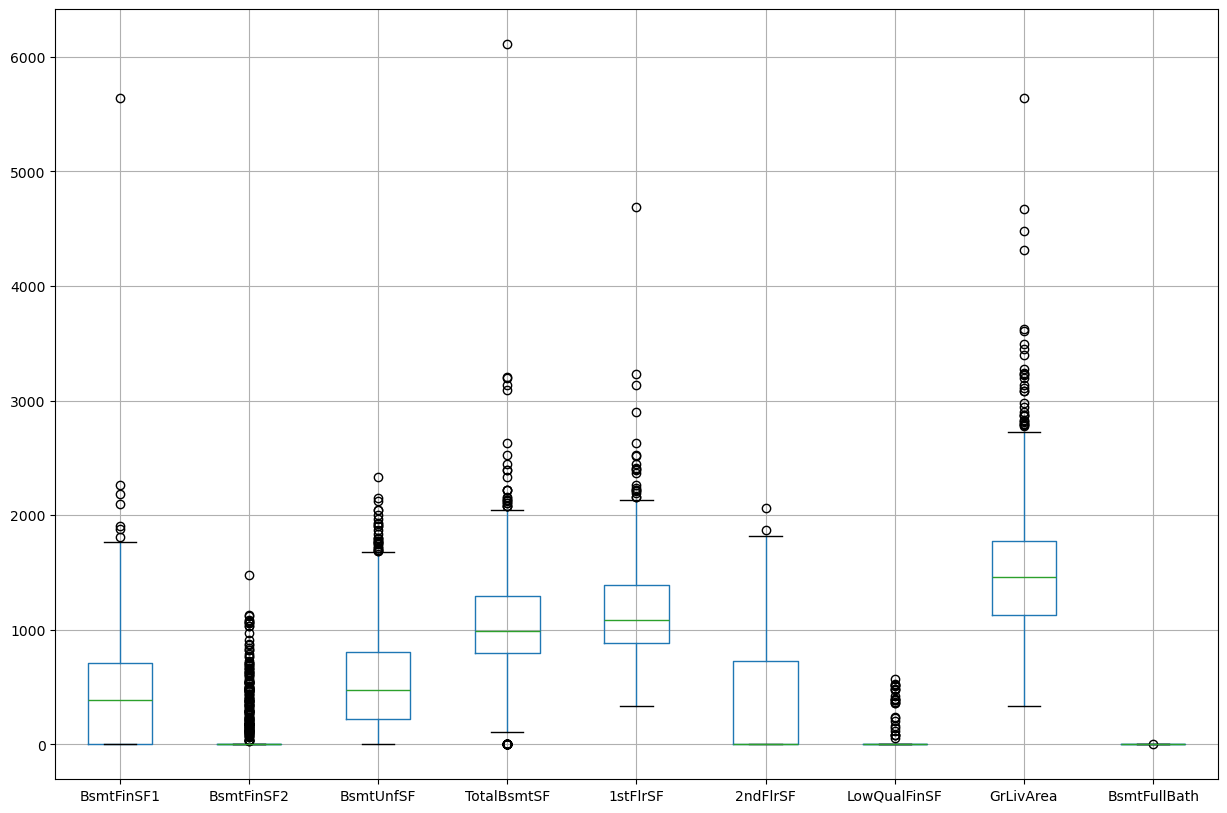

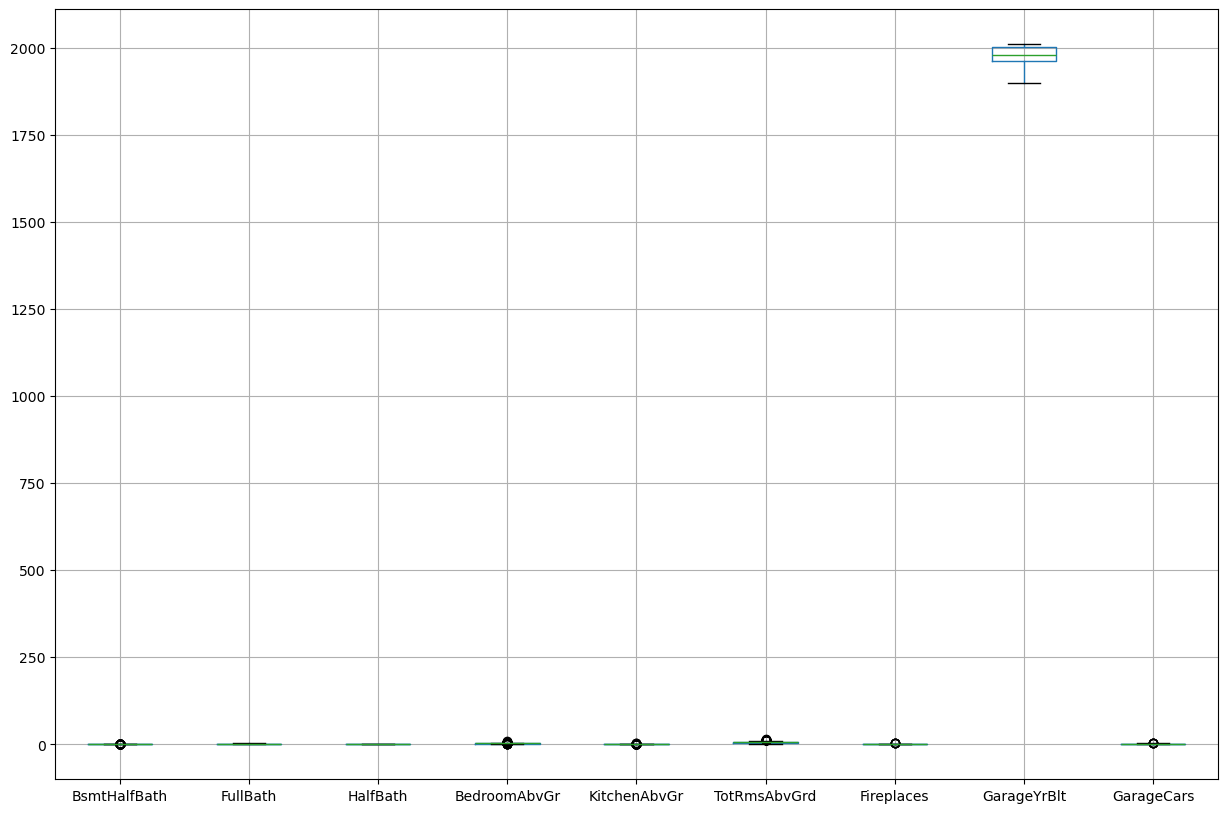

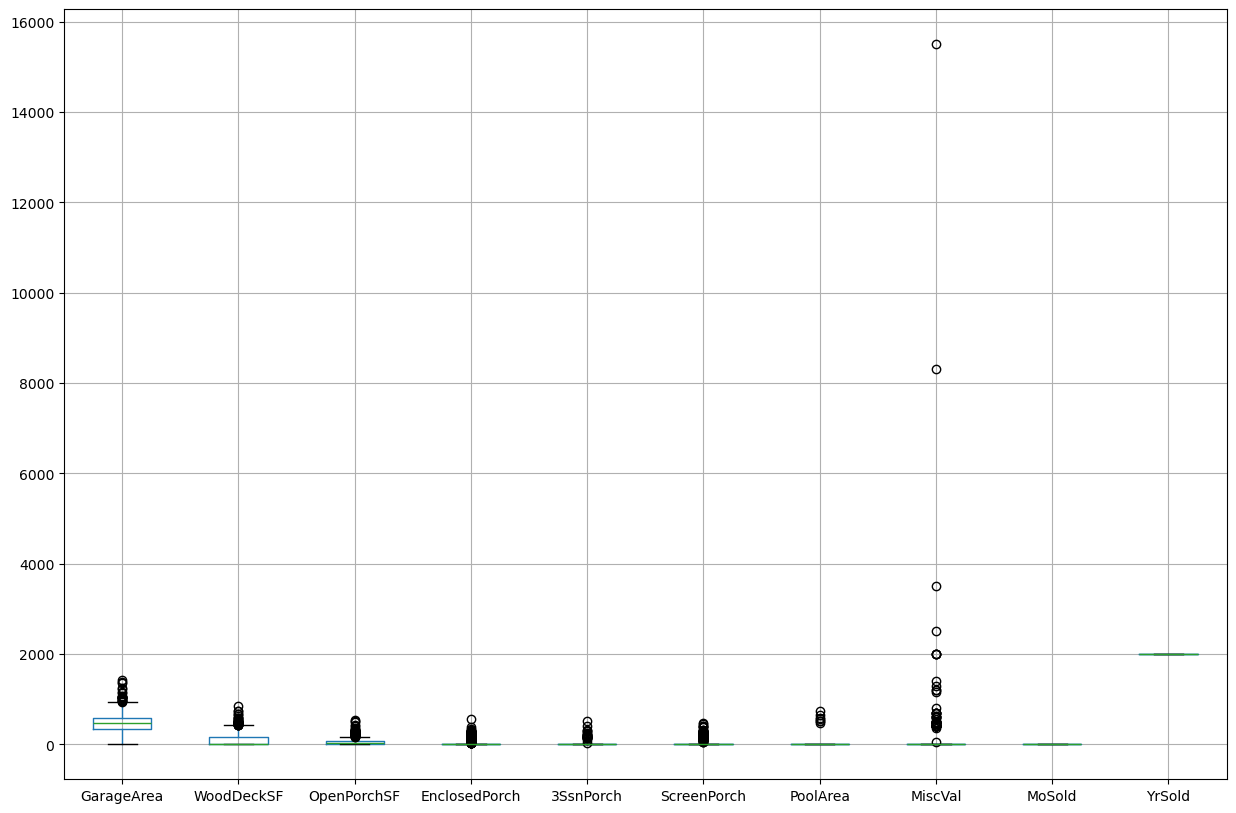

In [58]:
boxplot_columns(eda_numerical, 5)

In [21]:
eda_numerical.query('LotArea > 200000')["GrLivArea"]

313    2036
Name: GrLivArea, dtype: int64

In [22]:
eda_numerical.query('LotArea > 10000 and LotArea < 20000')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,235,204,228,0,0,0,350,11,2009,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1441,70,79.0,11526,6,7,1922,1994,0.0,0,...,431,0,0,0,0,0,0,9,2008,191000
1442,1443,60,85.0,11003,10,5,2008,2008,160.0,765,...,168,52,0,0,0,0,0,4,2009,310000
1448,1449,50,70.0,11767,4,7,1910,2000,0.0,0,...,168,24,0,0,0,0,0,5,2007,112000
1453,1454,20,90.0,17217,5,5,2006,2006,0.0,0,...,36,56,0,0,0,0,0,7,2006,84500


In [59]:
get_outliers_df(eda_numerical)

UndefinedVariableError: name 'nan' is not defined